In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import os
import matplotlib.pyplot as plt

torch.manual_seed(777) # reproducibility

In [2]:
def MinMaxScaler(data):
  ''' 
  Min Max Normalization

  Parameters
  ----------
  data : numpy.ndarray
    input data to be normalized
    shape: [Batch size, dimension]

  Returns
  ----------
  data : numpy.ndarry
    normalized data
    shape: [Batch size, dimension]
  '''
  numerator = data - np.min(data, 0)
  denominator = np.max(data, 0) - np.min(data, 0)
  # noise term prevents the zero division
  return numerator / (denominator + 1e-7)

In [3]:
# train Parameters
learning_rate = 0.01
num_epochs = 500
input_size = 5
hidden_size = 5
num_classes = 1
timesteps = seq_length = 7
num_layers = 1 # number of layers in RNN

In [4]:
# Open, High, Low, Volume, Close
xy = np.loadtxt('data-02-stock_daily.csv', delimiter = ',')
xy = xy[::-1] # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]] # Close as label

In [5]:
# build a dataset
dataX = []
dataY = []

for i in range(0, len(y) - seq_length):
  _x = x[i:i + seq_length]
  _y = y[i + seq_length] # Next close price
  print(_x, "->", _y)
  dataX.append(_x)
  dataY.append(_y)

Streaming output truncated to the last 5000 lines.
 [0.15782902 0.15470702 0.12791016 0.60962624 0.12692483]
 [0.1207904  0.11770961 0.11162416 0.22934481 0.10512477]] -> [0.12316526]
[[0.11044525 0.12724798 0.11435324 0.35107108 0.11089532]
 [0.12705592 0.1390988  0.12324434 0.23008873 0.11649107]
 [0.12288872 0.12276776 0.09067269 0.34481491 0.12791587]
 [0.14089803 0.17638508 0.15387945 0.4378686  0.18649648]
 [0.15782902 0.15470702 0.12791016 0.60962624 0.12692483]
 [0.1207904  0.11770961 0.11162416 0.22934481 0.10512477]
 [0.09905103 0.11924158 0.11722888 0.21129336 0.12316526]] -> [0.10022843]
[[0.12705592 0.1390988  0.12324434 0.23008873 0.11649107]
 [0.12288872 0.12276776 0.09067269 0.34481491 0.12791587]
 [0.14089803 0.17638508 0.15387945 0.4378686  0.18649648]
 [0.15782902 0.15470702 0.12791016 0.60962624 0.12692483]
 [0.1207904  0.11770961 0.11162416 0.22934481 0.10512477]
 [0.09905103 0.11924158 0.11722888 0.21129336 0.12316526]
 [0.11405885 0.10952968 0.11353161 0.18323922

In [6]:
# train/test split
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)
trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)

In [7]:
class LSTM(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length
    # Set parameters for RNN block
    # Note: batch_first=False by default.
    # When true, inputs are (batch_size, sequence_length, input_dimension)
    # instead of (sequence_length, batch_size, input_dimension)
    self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                        num_layers = num_layers, batch_first = True)
    # Fully connected layer
    self.fc = nn.Linear(hidden_size, num_classes)
  
  def forward(self, x):
    # Initialize hidden and cell states
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    # Propagate input through LSTM
    _, (h_out, _) = self.lstm(x, (h_0, c_0))
    h_out = h_out.view(-1, self.hidden_size)
    out = self.fc(h_out)
    return out

In [8]:
# Instantiate RNN model
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [9]:
# Set loss and optimizer function
criterion = torch.nn.MSELoss() # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr = learning_rate)

In [10]:
# Train the model
for epoch in range(num_epochs):
  outputs = lstm(trainX)
  optimizer.zero_grad()
  # obtain the loss function
  loss = criterion(outputs, trainY)
  loss.backward()
  optimizer.step()
  print("Epoch: %d, loss: %1.5f" % (epoch, loss.data))

print("Learning finished!")

Epoch: 0, loss: 0.06277
Epoch: 1, loss: 0.05901
Epoch: 2, loss: 0.05648
Epoch: 3, loss: 0.05414
Epoch: 4, loss: 0.05192
Epoch: 5, loss: 0.04987
Epoch: 6, loss: 0.04800
Epoch: 7, loss: 0.04627
Epoch: 8, loss: 0.04455
Epoch: 9, loss: 0.04268
Epoch: 10, loss: 0.04061
Epoch: 11, loss: 0.03836
Epoch: 12, loss: 0.03597
Epoch: 13, loss: 0.03348
Epoch: 14, loss: 0.03088
Epoch: 15, loss: 0.02809
Epoch: 16, loss: 0.02505
Epoch: 17, loss: 0.02178
Epoch: 18, loss: 0.01834
Epoch: 19, loss: 0.01486
Epoch: 20, loss: 0.01145
Epoch: 21, loss: 0.00826
Epoch: 22, loss: 0.00546
Epoch: 23, loss: 0.00331
Epoch: 24, loss: 0.00216
Epoch: 25, loss: 0.00217
Epoch: 26, loss: 0.00320
Epoch: 27, loss: 0.00473
Epoch: 28, loss: 0.00608
Epoch: 29, loss: 0.00672
Epoch: 30, loss: 0.00653
Epoch: 31, loss: 0.00573
Epoch: 32, loss: 0.00464
Epoch: 33, loss: 0.00353
Epoch: 34, loss: 0.00263
Epoch: 35, loss: 0.00203
Epoch: 36, loss: 0.00176
Epoch: 37, loss: 0.00174
Epoch: 38, loss: 0.00189
Epoch: 39, loss: 0.00212
Epoch: 40,

In [11]:
# Test the model
lstm.eval()
test_predict = lstm(testX)

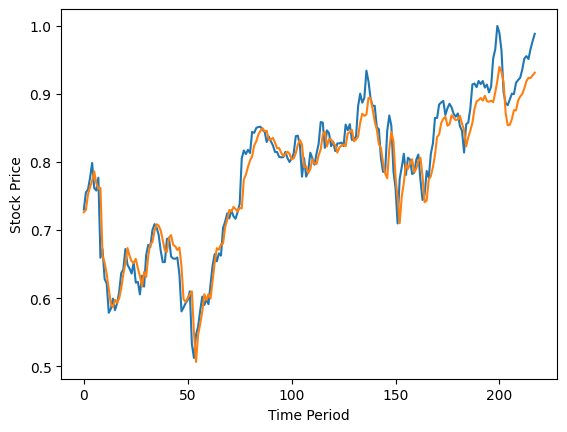

In [12]:
# Plot predictions
test_predict = test_predict.data.numpy()
testY = testY.data
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()